## Load modules

In [1]:
import numpy as np
import imp
import ens_snapshot_tools as ens
import matplotlib.pyplot as plt

# for debugging
# imp.reload(ens)

# Luke's
import utils #utils file with functions
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import numpy as np
import xarray as xr
import xesmf as xe
from scipy import stats
from scipy import signal
import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
#from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.cm as cm

import utils

## Load control run

In [21]:
out = np.load('input/CESM_ctrl_wtd_SVD.npz')

u    = out['u']
s    = out['s']
vt   = out['vt']
lat  = out['lat']
lon  = out['lon']
time = out['time']
nt   = out['nt']
nlat = out['nlat']
nlon = out['nlon']



## Load LME

In [19]:
out = np.load('input/CESM_LME_all13_wtd_SVD.npz')

u    = out['u']
s    = out['s']
vt   = out['vt']
lat  = out['lat']
lon  = out['lon']
time = out['time']
nt   = out['nt']
nlat = out['nlat']
nlon = out['nlon']

## Compute time-varying, reduced-space covariance matrices

In [28]:
binsize = 1

nEOF = 100

datr = s[:nEOF]*vt[:,:nEOF]

# Get time-varying reduced-space covariances
[C,tC]        = ens.mk_covs(datr,time,binsize)
[td,_,_]      = C.shape
Cv            = C.reshape(td,nEOF**2).T

plt.plot(np.cumsum(s**2)/np.sum(s**2))

ValueError: not enough values to unpack (expected 3, got 2)

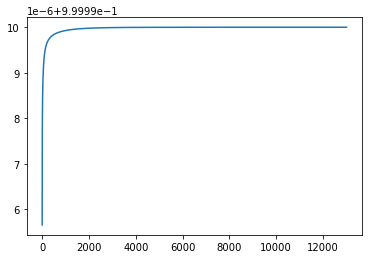

In [27]:
out = np.load('output/CESM_LME_13AllForcing_ReducedEOFs_nEOF_200.npz')
datr = out['datr']
udat = out['udat']
s    = out['s']

binsize = 1

time = np.arange(850,1850)

nEOF = 200

# Get time-varying reduced-space covariances
[C,tC]        = ens.mk_covs(datr,time,binsize)
[td,_,_]      = C.shape
Cv            = C.reshape(td,nEOF**2).T

plt.plot(np.cumsum(s**2)/np.sum(s**2))

## Compute K-L divergence for LME

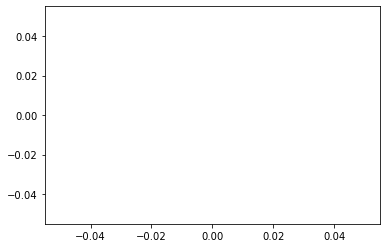

In [28]:

Cm = Cv.mean(axis=1, keepdims=True).reshape(nEOF,nEOF)
m0 = np.zeros(nEOF)
m1 = np.zeros(nEOF)

kld = np.empty(td)
for ii in np.arange(td):
    kld[ii]   = ens.KLdiv(C[ii,:,:],Cm,m0,m1)
    
plt.plot(tC,kld)

## Compute K-L divergence for control run

In [50]:
ds_TS = u.dot(np.diag(s)).dot(vt).reshape(1000,nlat,nlon)

[nt,nlat,nlon] = np.shape(ds_TS);

# Reshape the control run to look like a short ensemble simulation with 13 members
# New time length for these is 978 = 13*76
cnens = 13;
tdn   = int(np.floor(1000./cnens)*cnens)
el    = int(tdn/cnens)

# Reshape to give an ensemble axis and transpose to make the ordering consistent
ce = ds_TS[:(tdn),:,:].reshape(el,cnens,nlat*nlon).transpose([0,2,1])

# Need to compute reduced-space form
nEOF = 200
[cer,uce,sce]   = ens.reduce_space(ce,nEOF)

Text(0.5, 1.0, 'Baseline control K-L divergence')

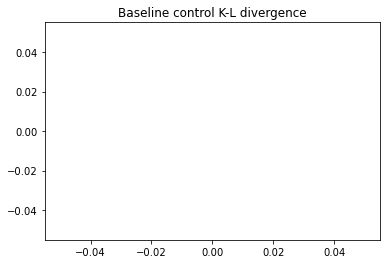

In [53]:
# Get time-varying reduced-space covariances
[Cc,tCc]        = ens.mk_covs(cer,np.arange(tdn),binsize)
[tdc,_,_]      = Cc.shape
Cvc            = Cc.reshape(tdc,nEOF**2).T

Cmc = Cvc.mean(axis=1, keepdims=True).reshape(nEOF,nEOF)
m0 = np.zeros(nEOF)
m1 = np.zeros(nEOF)

kldc = np.empty(tdc)
for ii in np.arange(tdc):
    kldc[ii]   = ens.KLdiv(Cc[ii,:,:],Cmc,m0,m1)
    
plt.plot(tCc,kldc)
plt.title('Baseline control K-L divergence')

## Compute dominant changes to covariance

In [ ]:
# Remove the time mean covariance
Cnm           = Cv - Cv.mean(axis=0, keepdims=True)
[uC,sC,vCt]   = np.linalg.svd(Cnm, full_matrices=False)

# Plot this many PCs
pltn          = 40

plt.plot(tC,(vCt[:pltn,:]*sC[:pltn,None]).T)

# Plot EOFs of the leading nonstationarity matrix
[uu,ss,_]    = np.linalg.svd(uC(:,0).reshape(nEOF,nEOF),full_matrices=False)

# Nontrivial to project back into physical space. Will give non-orthogonal patterns. Have to think more.


In [ ]:
# Regress forcing time series onto covariances to obtain patterns of non-stationarity associated with forcing
# Need to get time series of forcing amplitudes (global mean) to do this. I would hypothesize that if we remove the patterns associated with
# these regressions (maybe at some lag?) computed for all forcing time series then we'd get back variability that has K-L divergence indistinguishable from the control run!

#fts = np.random.randn(len(tC))
#proj = Cnm.dot(fts.T)